# Synthetic Data Generation Strategy 2: Upsampling KEGG Pathways and sampling from a multivariate normal

## Outline:

1.  Get mean/covariance matrix from empirical data
2.  Get pathway information from KEGG database
3.  Change mean values of proteins in pathway
4.  Randomly draw from multivariate normal distribution.

In [2]:
%pylab inline
import numpy as np
import pandas as pd
import pickle as pkl

from sklearn.covariance import GraphLasso

Populating the interactive namespace from numpy and matplotlib


# 1. Get mean/covariance matrix

Let's use the Ovarian cancer data since it's nicely compact. We'll use the Experimental InBioMap PPI. 

In [3]:
ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/ovarian_inbiomap_exp.tsv', index_col=0)

ovarian.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
PNNL-TCGA-09-1664,0.0,-0.119,-0.1880,0.5710,-0.224000,0.3320,0.0,-0.2160,0.205,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1484,0.0,0.000,-0.1210,-1.4500,0.079000,0.1030,0.0,-0.9750,0.000,0.175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1488,0.0,0.000,-0.2190,-0.0765,-1.340000,-0.4200,0.0,0.0158,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1489,0.0,0.000,0.2360,0.7490,0.107000,-0.0168,0.0,-0.1470,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNNL-TCGA-13-1494,0.0,0.433,0.0158,-0.2100,0.000859,-0.5270,0.0,0.0926,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
means = ovarian.mean(axis=0)
covariances = ovarian.cov()
variances = ovarian.var()
means.shape, covariances.shape, variances.shape

((16349,), (16349, 16349), (16349,))

# 2. Retrieve KEGG pathways

(pathways found at http://rest.kegg.jp/list/pathway/hsa)


In [5]:
pathways = pkl.load(open("../KEGG_pathway_gene_lists.pkl", "rb"))
pathway_id = "hsa00830"
pathway_genes = np.array(pathways[pathway_id])
pathway_genes

array(['BCO1', 'ADH1A', 'ADH1B', 'ADH1C', 'ADH7', 'ADH4', 'ADH5', 'ADH6',
       'DHRS3', 'DHRS4', 'DHRS4L1', 'DHRS4L2', 'DHRS9', 'RDH8', 'RDH10',
       'RDH11', 'RDH12', 'RDH16', 'SDR16C5', 'HSD17B6', 'LRAT', 'DGAT1',
       'AWAT2', 'PNPLA4', 'RPE65', 'RDH5', 'AOX1', 'ALDH1A2', 'ALDH1A1',
       'CYP26A1', 'CYP26B1', 'CYP26C1', 'CYP1A1', 'CYP1A2', 'CYP2A6',
       'CYP2B6', 'CYP2C8', 'CYP2C9', 'CYP2C18', 'CYP2S1', 'CYP3A4',
       'CYP3A5', 'CYP3A7', 'CYP3A7-CYP3A51P', 'CYP4A11', 'UGT2A1',
       'UGT2A3', 'UGT2B17', 'UGT2B11', 'UGT2B28', 'UGT1A6', 'UGT1A4',
       'UGT1A1', 'UGT1A3', 'UGT2B10', 'UGT1A9', 'UGT2B7', 'UGT1A10',
       'UGT1A8', 'UGT1A5', 'UGT2B15', 'UGT1A7', 'UGT2B4', 'UGT2A2',
       'RETSAT'], 
      dtype='<U15')

# 3. Update multinomial distribution

- genes in pathway will have their means updated by an amount b. 
- b is drawn from a zero-centered normal with std given by the variation

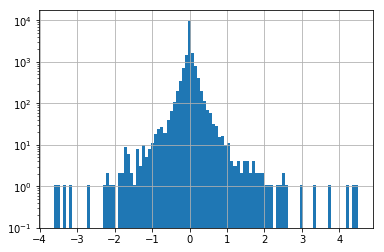

In [6]:
adjust_means = variances.apply(lambda x: np.random.normal(0,x))

fig, ax = plt.subplots()
adjust_means.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [7]:
adjust_pathway_means = pd.DataFrame(adjust_means[pathway_genes], columns=["adjust_means"]).fillna(0)
adjust_pathway_means = adjust_pathway_means[adjust_pathway_means.adjust_means != 0]
adjust_pathway_means

,adjust_means
ADH1A,-0.485597
ADH1B,-2.229136
ADH1C,-2.280619
ADH7,0.044538
ADH4,-0.179593
ADH5,0.086320
DHRS3,0.263886
DHRS4,-0.458351
RDH10,-0.154830
RDH11,0.100076


In [8]:
means = pd.DataFrame(means, columns=["mean"]).merge(adjust_pathway_means, left_index=True, right_index=True, how="left").fillna(0)
means.head()

,mean,adjust_means
ZNF91,0.000000,0.0
NDEL1,0.010325,0.0
ELAVL1,0.031412,0.0
SUMO1,0.126737,0.0
SUMO3,-0.039357,0.0


In [9]:
updated_means = means.sum(axis=1)
updated_means.head()

ZNF91     0.000000
NDEL1     0.010325
ELAVL1    0.031412
SUMO1     0.126737
SUMO3    -0.039357
dtype: float64

# 4. Sample from multivariate gaussian
 

In [ ]:
values = np.random.multivariate_normal(updated_means, covariances, 1)
values.shape


The issue with this approach is that it takes a pretty long time (http://stackoverflow.com/questions/40100340/numpy-multivariate-normal-bug-when-dimension-too-high/40197926) so I'm going to generate a dataset which naively assumes proteins are independent in another notebook...